In [1]:
import torch.nn as nn
import torch

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def random_perturb(x):
        """
        """
        l = len(x.shape) - 1
        rp = torch.randn_like(x)
        rp_norm = rp.view(rp.shape[0], -1).norm(dim=1).view(-1, *([1]*l))
        return torch.clamp(x + 0.01 * rp / (rp_norm + 1e-10), 0, 1)

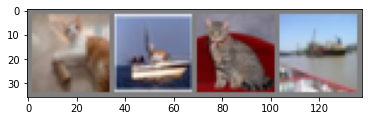

cat   ship  cat   ship 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
images[0].shape

torch.Size([3, 32, 32])

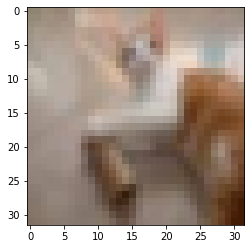

cat   ship  cat   ship 


In [7]:

imshow(torchvision.utils.make_grid(images[0]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

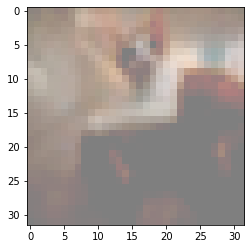

cat   ship  cat   ship 


In [8]:

imshow(torchvision.utils.make_grid(random_perturb(images[0])))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
from google.colab import files
uploaded = files.upload()
PATH = './cifar_net.pth'

In [ ]:
import torch
import torch.nn as nn


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):


    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64):
        super(Bottleneck, self).__init__()
  
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)

        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * 4)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64):
        super(ResNet, self).__init__()
  

        self.inplanes = 64


        self.groups = groups

        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(Bottleneck, 64, 3)

        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)

        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)

        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
 
        downsample = None

        if stride != 1 or self.inplanes != planes * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * 4),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width))
        self.inplanes = planes * 4
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x




net = ResNet()
net.load_state_dict(torch.load(PATH))
net = net.cuda()


In [75]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        input, label = data
        inputs = []
        labels = []
        for inp in range(len(input)):
          inputs.append(torch.cat(( random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]),random_perturb(images[inp]) ), 0).reshape(10,3,32,32))
          labels.append(torch.tensor([label[inp]]*10))
        labels = torch.cat(labels)
        inputs = torch.cat(inputs)        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

print('Finished Training')

In [116]:

torch.save(net.state_dict(), PATH)

In [1]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %
